<a href="https://colab.research.google.com/github/talmeillet/Melanoma-Detector/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model 1**

Setting kaggle API in order to import our dataset

In [ ]:
# Importing gdown to download the file
!pip install gdown
# URL of the file on Google Drive
file_url = "https://drive.google.com/uc?id=1wIAN3-w7FpE893ynMvOxRO6smQ96adTx"
# Command to download the file
!gdown {file_url}
#install kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Downloading...
From: https://drive.google.com/uc?id=1wIAN3-w7FpE893ynMvOxRO6smQ96adTx
To: /content/kaggle.json
100% 66.0/66.0 [00:00<00:00, 129kB/s]


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2

Importing the dataset-
* dataset link: https://www.kaggle.com/datasets/cdeotte/jpeg-melanoma-512x512


In [ ]:
# Download latest version
path = kagglehub.dataset_download("cdeotte/jpeg-melanoma-512x512")
print("Path to dataset files:", path)

100%|██████████| 2.63G/2.63G [00:44<00:00, 63.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cdeotte/jpeg-melanoma-512x512/versions/3


opening the train data from our dataset

In [ ]:
# path of  the csv and the image folder
train_csv_path = os.path.join(path, "train.csv")
image_folder_path = os.path.join(path, "train")

# Load CSV data
df_train = pd.read_csv(train_csv_path)

# Add .jpg extension to image names for matching
df_train['image_name'] = df_train['image_name'].apply(lambda x: f"{x}.jpg")

selecting only 6550 pictures- 550 are labeled as cancer detcted and 6000 as no cancer

In [ ]:
df = pd.read_csv(train_csv_path)
print("CSV Loaded. Columns:", df.columns)

#taking from the dataset 6550 images
#550 pictures of melanoma (this is the maximum we have on the dataset) and the rest is not melanoma
df_0 = df[df['target'] == 0].sample(n=6000, random_state=42)  # no cancer
df_1 = df[df['target'] == 1].sample(n=550, random_state=42)  # cancer

CSV Loaded. Columns: Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'tfrecord', 'width', 'height'],
      dtype='object')


In [ ]:
# do ogmentation to images that target=1, in order to have 3000 imgaes like this
def augment_image(image_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image at {image_path}")
        return

    # Define augmentation functions
    def rotate(img, angle):
        rows, cols, _ = img.shape
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        return cv2.warpAffine(img, M, (cols, rows))

    def flip(img, vflip, hflip):
        if vflip:
          img = cv2.flip(img, 0)
        if hflip:
          img = cv2.flip(img, 1)
        return img

    def add_noise(img):
        noise = np.random.normal(0, 0.05, img.shape).astype(np.float32)
        return np.clip(img + noise, 0, 255).astype(np.uint8)

    # Apply augmentations randomly
    augmentations = [
        lambda img: rotate(img, random.uniform(-15, 15)),
        lambda img: flip(img, random.choice([True, False]), random.choice([True, False])),
        lambda img: add_noise(img),
    ]

    augmented_image = image.copy()
    for _ in range(random.randint(1,3)):  # Apply 1 to 3 augmentations
      augmented_image = random.choice(augmentations)(augmented_image)

    cv2.imwrite(output_path, augmented_image)

# Create output directory if it doesn't exist
output_dir = "augmented_images"
os.makedirs(output_dir, exist_ok=True)

# Get list of images with target = 1
target_1_images = df_train[df_train['target'] == 1]['image_name'].tolist()

# Number of images to generate
num_images_to_generate = 3000 - len(target_1_images)

# Perform augmentation for each image with target=1
for image_name in target_1_images:
  image_path = os.path.join(image_folder_path, image_name)
  output_path = os.path.join(output_dir, image_name)
  augment_image(image_path, output_path)

# Generate more augmented images until we reach 3000
for i in range(num_images_to_generate):
  image_name = random.choice(target_1_images)
  image_path = os.path.join(image_folder_path, image_name)
  new_image_name = f"augmented_{i}_{image_name}"
  output_path = os.path.join(output_dir, new_image_name)
  augment_image(image_path, output_path)

In [ ]:
import shutil

#creating folders to classification
train_dir = '/content/dataset/train'
os.makedirs(f"{train_dir}/0", exist_ok=True)
os.makedirs(f"{train_dir}/1", exist_ok=True)

# copying images to the folders
print("Copying images...")
for _, row in df_0.iterrows():
    src = os.path.join(path, "train", f"{row['image_name']}.jpg")
    dest = os.path.join(f"{train_dir}/0", f"{row['image_name']}.jpg")
    if os.path.exists(src):
        shutil.copy(src, dest)

for _, row in df_1.iterrows():
    src = os.path.join(path, "train", f"{row['image_name']}.jpg")
    dest = os.path.join(f"{train_dir}/1", f"{row['image_name']}.jpg")
    if os.path.exists(src):
        shutil.copy(src, dest)


Copying images...


In [ ]:
# Add augmented images to the training directory
augmented_images_dir = "/content/augmented_images"
for filename in os.listdir(augmented_images_dir):
    source_path = os.path.join(augmented_images_dir, filename)
    destination_path = os.path.join(f"{train_dir}/1", filename)
    shutil.copy(source_path, destination_path)


In [ ]:
# checking the content in the folders
print("Number of images in '0':", len(os.listdir(f"{train_dir}/0")))
print("Number of images in '1':", len(os.listdir(f"{train_dir}/1")))

Number of images in '0': 6000
Number of images in '1': 3000


Preprocessing the images with functions from tensorflow:
### Description:
* Image Loading: The image is read from the specified file path using tf.io.read_file().
* Image Decoding: The image is decoded from JPEG format to a tensor with 3 color channels (RGB) using tf.image.decode_jpeg().
* Resizing: The image is resized to a fixed size of 64x64 pixels with tf.image.resize().
* Normalization: The pixel values are normalized to the range [0, 1] by dividing by 255, making the image ready for input into a neural network model.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)  # Efficient image loading
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG
    img = tf.image.resize(img, [64, 64])  # Resize to 64x64
    img = img / 255.0  # Normalize to [0, 1]
    return img

In [ ]:
# preprocess images with labels
preprocessed_images = []
labels = []

# preprocess images without melanoma
for img in os.listdir(f"{train_dir}/0"):
    img_path = os.path.join(train_dir, "0", img)
    preprocessed_images.append(preprocess_image(img_path))
    labels.append(0)

# preprocess images with melanoma
for img in os.listdir(f"{train_dir}/1"):
    img_path = os.path.join(train_dir, "1", img)
    preprocessed_images.append(preprocess_image(img_path))
    labels.append(1)

print(f"Processed {len(preprocessed_images)} images with labels.")


Processed 9000 images with labels.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert preprocessed images and labels to NumPy arrays
X = np.array(preprocessed_images)  # Processed images
y = np.array(labels)               # Corresponding labels (0 = no melanoma, 1 = melanoma)

# Find indices of class 1 and class 0
class_1_indices = np.where(y == 1)[0]
class_0_indices = np.where(y == 0)[0]

# Shuffle the indices for randomness
np.random.seed(42)  # For reproducibility
np.random.shuffle(class_1_indices)
np.random.shuffle(class_0_indices)

# Split class 1 into 600 for validation and the rest for training
val_class_1_indices = class_1_indices[:600]
train_class_1_indices = class_1_indices[600:]

# Split class 0 into the remaining validation and training sets
val_class_0_count = len(val_class_1_indices) * 4  # Maintain 80-20 ratio
val_class_0_indices = class_0_indices[:val_class_0_count]
train_class_0_indices = class_0_indices[val_class_0_count:]

# Combine the training and validation indices
train_indices = np.concatenate([train_class_1_indices, train_class_0_indices])
val_indices = np.concatenate([val_class_1_indices, val_class_0_indices])

# Shuffle the indices within each set for randomness
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

# Create training and validation sets
X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]


## Model Definition and Compilation
This code defines and compiles a Convolutional Neural Network (CNN) for binary classification tasks, such as image classification (e.g., distinguishing between two categories).

### Model Architecture:
* **Conv2D Layer:**
First convolutional layer with 32 filters of size 3x3.
ReLU activation function is applied for non-linearity.
* **MaxPooling2D Layer:**
Max pooling operation with a pool size of 2x2 to reduce spatial dimensions.
* **Conv2D Layer**:
Second convolutional layer with 64 filters of size 3x3.
ReLU activation function.
* **MaxPooling2D Layer:**
Another max pooling operation with a pool size of 2x2.
* **Flatten Layer:**
Flatten the 2D output from the convolutional layers into a 1D vector.
* **Dense Layer (128 units):**
Fully connected layer with 128 neurons and ReLU activation.
* **Dense Layer (1 unit):**
Output layer with 1 unit and a sigmoid activation function, suitable for binary classification (outputs a value between 0 and 1).
* The model is compiled with the Adam optimizer and binary crossentropy loss, using accuracy, precision, and recall as evaluation metrics.


In [ ]:
from tensorflow.keras import metrics
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
# Define the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

# The input shape for the first Dense layer is automatically inferred
# based on the output of the Flatten layer.
# You don't need to specify it manually.

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.Precision(), metrics.Recall()])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
class_weight = {0: 1.0, 1: 1.1}

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 69s 346ms/step - accuracy: 0.7507 - loss: 1.2418 - precision: 0.6844 - recall: 0.6964 - val_accuracy: 0.6520 - val_loss: 1.1384 - val_precision: 0.3564 - val_recall: 0.9183
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 338ms/step - accuracy: 0.8096 - loss: 0.5596 - precision: 0.8132 - recall: 0.6869 - val_accuracy: 0.8667 - val_loss: 0.4774 - val_precision: 0.6582 - val_recall: 0.6933
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 63s 335ms/step - accuracy: 0.8366 - loss: 0.4864 - precision: 0.8396 - recall: 0.7293 - val_accuracy: 0.8767 - val_loss: 0.4214 - val_precision: 0.7091 - val_recall: 0.6500
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 333ms/step - accuracy: 0.8436 - loss: 0.4355 - precision: 0.8501 - recall: 0.7441 - val_accuracy: 0.8597 - val_loss: 0.4043 - val_precision: 0.6255 - val_recall: 0.7433
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 338ms/step - accuracy: 0.8688 - loss: 0.3799 - precision: 0.8712 - recall: 0.7903 - val_accuracy: 0.8967

prediction to the test for the model

In [ ]:
import os
import numpy as np

def check_test_folder_and_predict(test_folder_path, model, max_images=6000, batch_size=32):
    image_files = [f for f in os.listdir(test_folder_path) if f.endswith('.jpg')][:max_images]
    predictions = []

    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i + batch_size]
        batch_images = []

        for image_file in batch_files:
            image_path = os.path.join(test_folder_path, image_file)
            try:
                img = preprocess_image(image_path)
                batch_images.append(img)
            except Exception as e:
                print(f"Error processing {image_file}: {e}")
                continue

        if batch_images:
            batch_images = np.array(batch_images)
            preds = model.predict(batch_images)
            preds = (preds > 0.5).astype(int).flatten()
            predictions.extend(preds)

    return predictions

# usage
test_folder_path = os.path.join(path, "test")
predictions = check_test_folder_and_predict(test_folder_path, model)
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━

Calculating F1 Score

In [ ]:
# calculate f1 score
from sklearn.metrics import f1_score

y_true = y_train
predictions = (model.predict(X_train) > 0.5).astype("int32")

f1 = f1_score(y_true, predictions)
print(f"F1 Score: {f1}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step
F1 Score: 0.7905871167102448


Visualizations of the training process:

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step


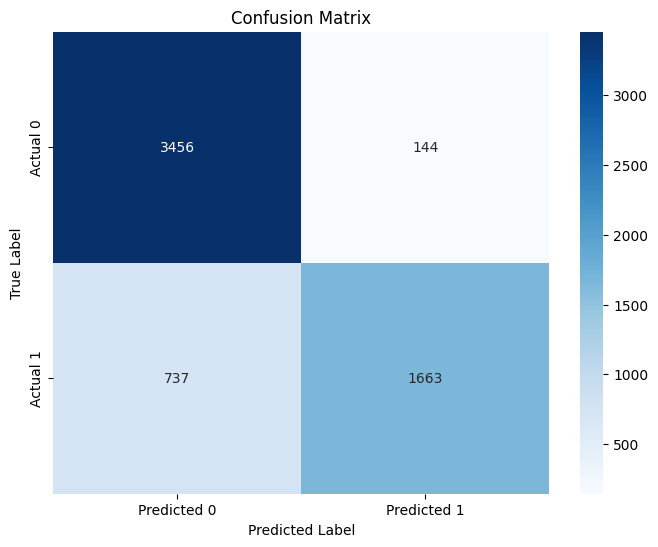

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = y_train
predictions = (model.predict(X_train) > 0.5).astype("int32")

# Calculate the confusion matrix
cm = confusion_matrix(y_true, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

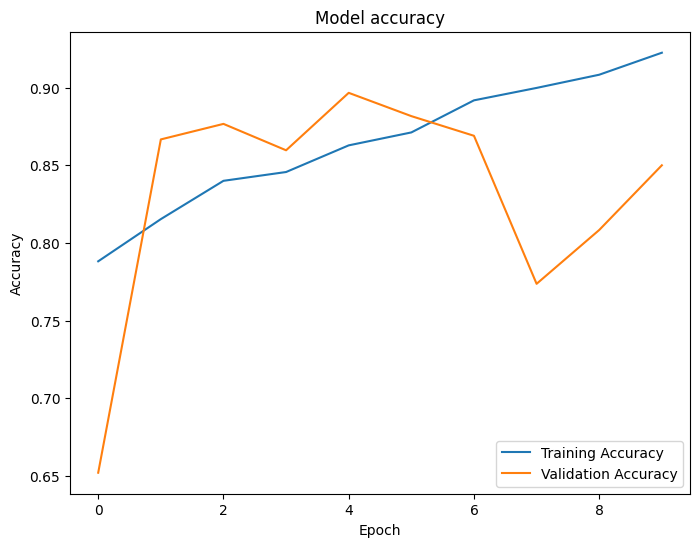

In [ ]:
#create a line plot of history- accuracy

# Plot training history (accuracy)
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

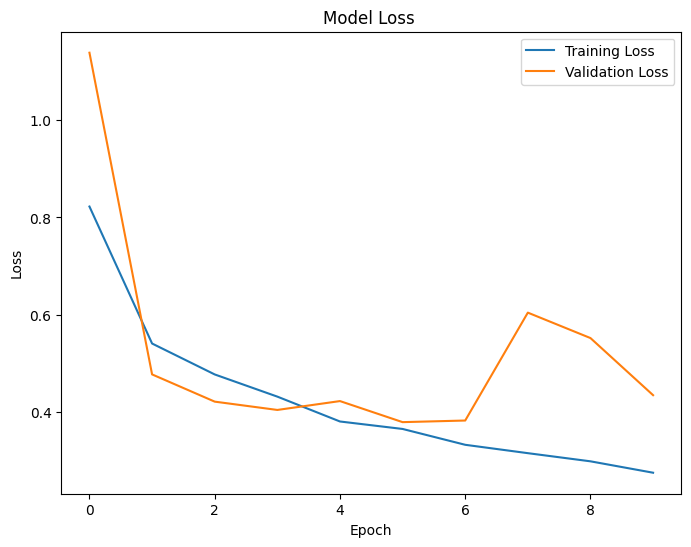

In [ ]:
# create a line plot of loss in history
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

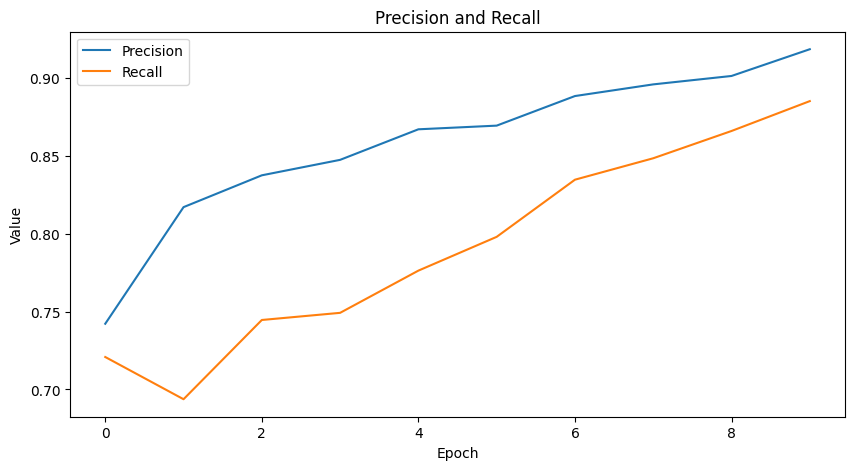

In [ ]:
# create a precision and recall visualization
plt.figure(figsize=(10, 5))
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Precision and Recall')
plt.show()

Saving WhatsApp Image 2025-01-09 at 10.16.28.jpeg to WhatsApp Image 2025-01-09 at 10.16.28.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction for WhatsApp Image 2025-01-09 at 10.16.28.jpeg: 1


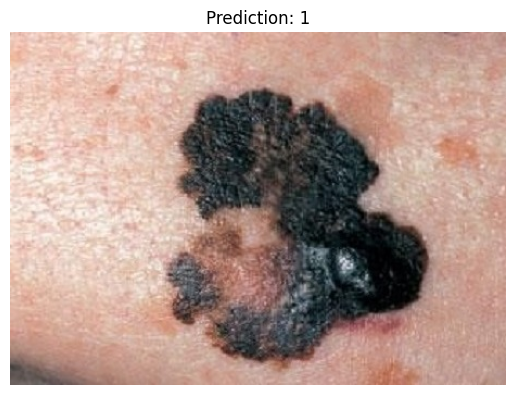

In [ ]:
# another prediction- takes any picture that we choose from our computer
from google.colab import files
import io
import numpy as np
from PIL import Image
import tensorflow as tf

uploaded = files.upload()

for fn in uploaded.keys():
  # Open the image using PIL
  image = Image.open(io.BytesIO(uploaded[fn]))

  # Convert to NumPy array
  image = np.array(image)

  # Preprocess the image
  img = tf.keras.preprocessing.image.img_to_array(image) # Convert PIL Image to NumPy array
  img = tf.image.convert_image_dtype(img, dtype=tf.float32)  # Convert data type if needed
  img = tf.image.resize(img, [64, 64]) # Resize
  img = img / 255.0  # Normalize to [0, 1]
  img = tf.expand_dims(img, axis=0) # Add batch dimension


  # Make the prediction
  prediction = model.predict(img)
  predicted_class = 1 if prediction > 0.5 else 0

  print(f"Prediction for {fn}: {predicted_class}")

  # Display the image
  import matplotlib.pyplot as plt
  plt.imshow(image)
  plt.title(f"Prediction: {predicted_class}")
  plt.axis('off')
  plt.show()